In [1]:
using HTTP
using DataFrames
using CSV

# get public data
# Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile
# https://github.com/pcm-dpc/COVID-19
res = HTTP.get("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
df = CSV.read(res.body);

In [2]:
# filter data
lombardia = filter(row -> row[:codice_regione] == 3, df)
filtered = lombardia[:, [:totale_casi, :dimessi_guariti, :deceduti]];

## The SIR model without vital dynamics
The dynamics of an epidemic, for example the flu, are often much faster than the dynamics of birth and death, therefore, birth and death are often omitted in simple compartmental models. The SIR system without so-called vital dynamics (birth and death, sometimes called demography) described above can be expressed by the following set of ordinary differential equations:

$$\frac{dS}{dt} = -\frac{\beta IS}{N}$$

$$\frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

where:

$$\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$$

$$S(t) + I(t) + R(t) = N$$

In [3]:
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
# polulation
N = 10e6
# infected
I = transpose(filtered[!, 1])
# i = 3.0 .* i
# death
d = transpose(filtered[!, 2])
# recovered
g = transpose(filtered[!, 3])
# recovered+death
R = d .+ g
# susceptible population
S = N .- I

data = vcat(S, I, R)
tinterval = 1:1:size(S)[2]
t = collect(tinterval);

In [5]:
using DifferentialEquations, ParameterizedFunctions

p = [1, 1, N]
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
f = function (du, u, p, t) # Define f as an in-place update into du
    β, γ = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

#5 (generic function with 1 method)

In [6]:
N = 10e6 # population
C = I[1] # init value infected population
# N-C -> init value susceptible population

u0 = [N-C; C; 0.0]; tspan = (0.0, 50.0)
prob = ODEProblem(f, u0, tspan, p);

In [7]:
using ParameterizedFunctions, OrdinaryDiffEq, DiffEqParamEstim
using BlackBoxOptim, NLopt, Plots, RecursiveArrayTools #, QuadDIRECT

# loc_bounds = Tuple{Float64, Float64}[(0, 5), (0, 5),]
glo_bounds = Tuple{Float64, Float64}[(0, 1), (0, 1),]
# loc_init = [1,0.5]
# glo_init = [5,5]

obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data),tstops=t)
res1 = bboptimize(obj;SearchRange = glo_bounds, MaxSteps = 1e5)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 6412 evals, 6329 steps, improv/step: 0.223 (last = 0.2229), fitness=294533216.648541987

Optimization stopped after 14712 steps and 0.93 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 15819.35
Function evals per second = 14124.73
Improvements/step = 0.01705
Total function evaluations = 13136


Best candidate found: [0.230605, 0.0443578]

Fitness: 294533216.648487151



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Too many steps (101) without any function evaluations (probably search has converged)", 14712, 1.584871953092e9, 0.9300000667572021, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 985059,:SearchRange => Tuple{Float64,Float64}[(0.0, 1.0), (0.0, 1.0)],:MaxSteps => 100000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 13136, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(2.9453321664848715e8, [0.23060511892730826, 0.044357754010852006]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([0.23060511892730826 0.23060511892730826 … 0.23060

In [8]:
p = [0.230605, 0.0443577, N]
u0 = [N-C; C; 0.0]; tspan = (0.0, 100.0)
prob = ODEProblem(f, u0, tspan, p);
# Solve the problem
sol = solve(prob,Tsit5(),reltol=1e-9,abstol=1e-9);

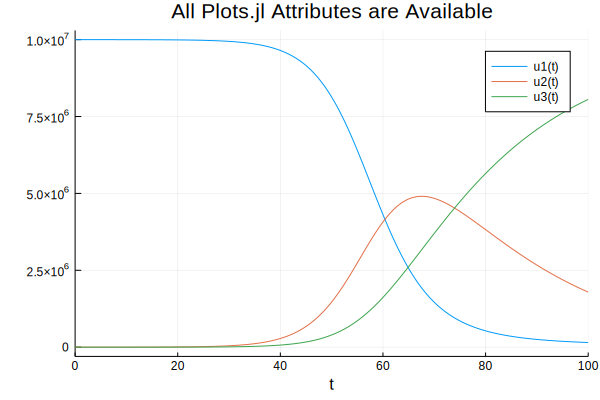

In [9]:
using Plots; gr() # Using the Plotly Backend
plot(sol,title="All Plots.jl Attributes are Available")